# CWFS vignette analysis

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: 2024-01-11 <br>
Software Versions:
  - `ts_wep`: **v8.1.0**
  - `ts_imsim`: **v0.10.0**

## Notebook Objective:

In this notebook we will analyze the effects of vignetting on WEP Zernike Estimation and the convergence of the AOS closed loop. At the end we will establish a limit on the distance from the center of the LSSTCam focal plane for sources we will use in the WEP pipeline.

This notebook is an updated version that replaces Phosim with imSim.

## Logistics

This notebook is intended to be run on the USDF . The data set is on the USDF at .

In [1]:
import os
import yaml
from lsst.daf.butler import Butler

from lsst.ts.wep.cwfs import Instrument
from lsst.ts.wep.utils import runProgram, writePipetaskCmd, getConfigDir, CamType
from lsst.ts.wep.task import DonutStamps
from lsst.ts.wep.task import CalcZernikesTask, CalcZernikesTaskConfig
from lsst.ts.wep.utils import ConvertZernikesToPsfWidth

import numpy as np
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt

from IPython.display import Image
from scipy.ndimage import rotate
%matplotlib inline

## Progression of vignetting across the intra-focal detectors

The following data set simulates a series of donuts across each of the intra-focal wavefront detectors at increasing distance from the center of the focal plane. In each image the center of the focal plane is in the direction of the bottom right corner of the detector and as sources are simulated closer to the top left corner the amount of vignetting increases.

In [2]:
# Repository with simulated data
supporting_data_folder = '/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/vignette_tests'
butler_repo = os.path.join(supporting_data_folder, 'single_donut_all', 'imsimData')
# Initialize the butler
butler = Butler(butler_repo)
registry = butler.registry

In [3]:
# Specify the data Ids
extraDataIds = {}
intraDataIds = {}
extraDetectorIds = [191, 195, 199, 203]
for extraDetectorNum in extraDetectorIds:
    intraDetectorNum = extraDetectorNum + 1
    dataIdExtra = {'instrument': 'LSSTCam', 'detector': extraDetectorNum, 'exposure': 5023062001000, 'visit': 5023062001000}
    dataIdIntra = {'instrument': 'LSSTCam', 'detector': intraDetectorNum, 'exposure': 5023062001000, 'visit': 5023062001000}
    extraDataIds[str(extraDetectorNum)] = dataIdExtra
    intraDataIds[str(intraDetectorNum)] = dataIdIntra

Here we show them across the detector with the distance from the focal plane.

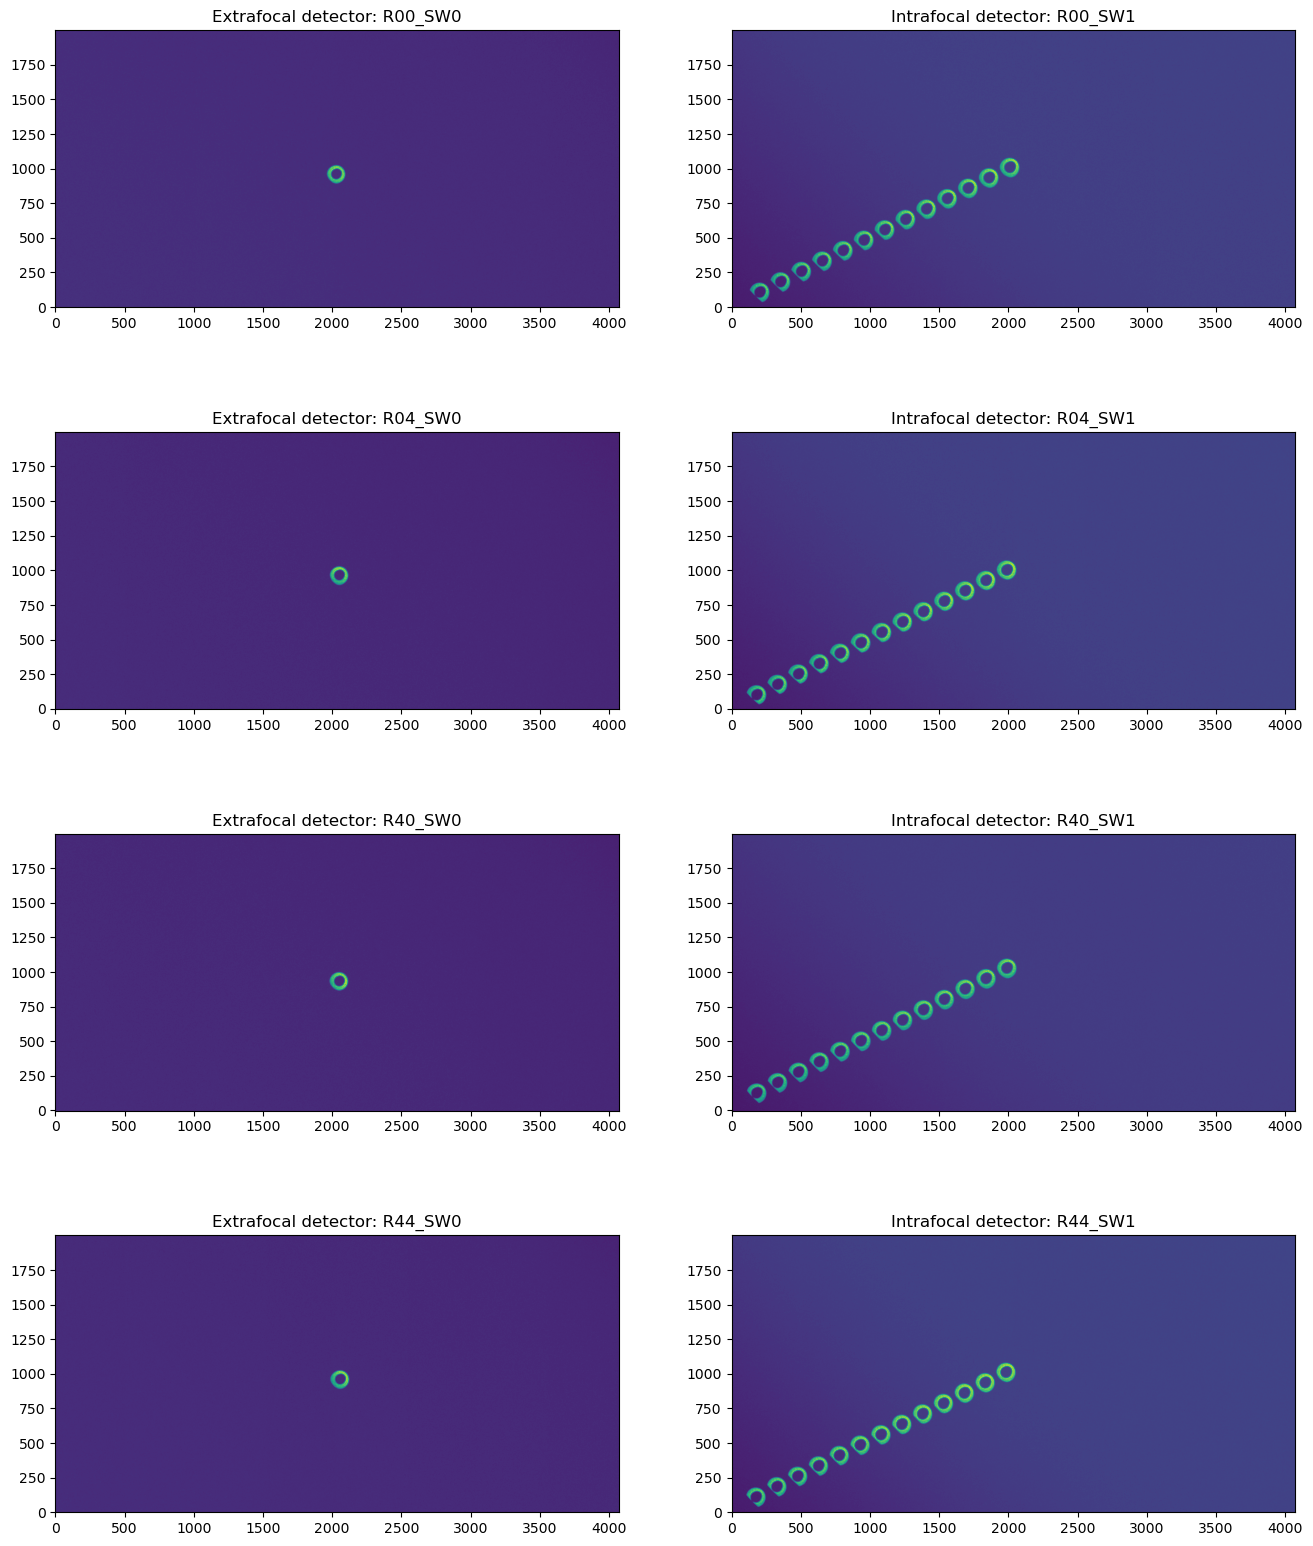

In [4]:
fig = plt.figure(figsize=(16, 20))
i = 1
for extraId in extraDetectorIds:
    fig.add_subplot(4, 2, i)
    extraIm = butler.get('postISRCCD', dataId=extraDataIds[str(extraId)], collections=['ts_imsim_1000'])
    plt.imshow(extraIm.getImage().getArray())
    extraDetectorName = extraIm.getDetector().getName()
    plt.title(f'Extrafocal detector: {extraDetectorName}')
    fig.add_subplot(4, 2, i+1)
    intraIm = butler.get('postISRCCD', dataId=intraDataIds[str(extraId+1)], collections=['ts_imsim_1000'])
    plt.imshow(intraIm.getImage().getArray())
    intraDetectorName = intraIm.getDetector().getName()
    plt.title(f'Intrafocal detector: {intraDetectorName}')
    i += 2

Let's take a closer look at the donuts by loading the `DonutStamps` for one of the detectors.

In [5]:
donutStampsIntra = butler.get('donutStampsIntra', dataId=dataIdExtra, collections=['ts_imsim_1000'])

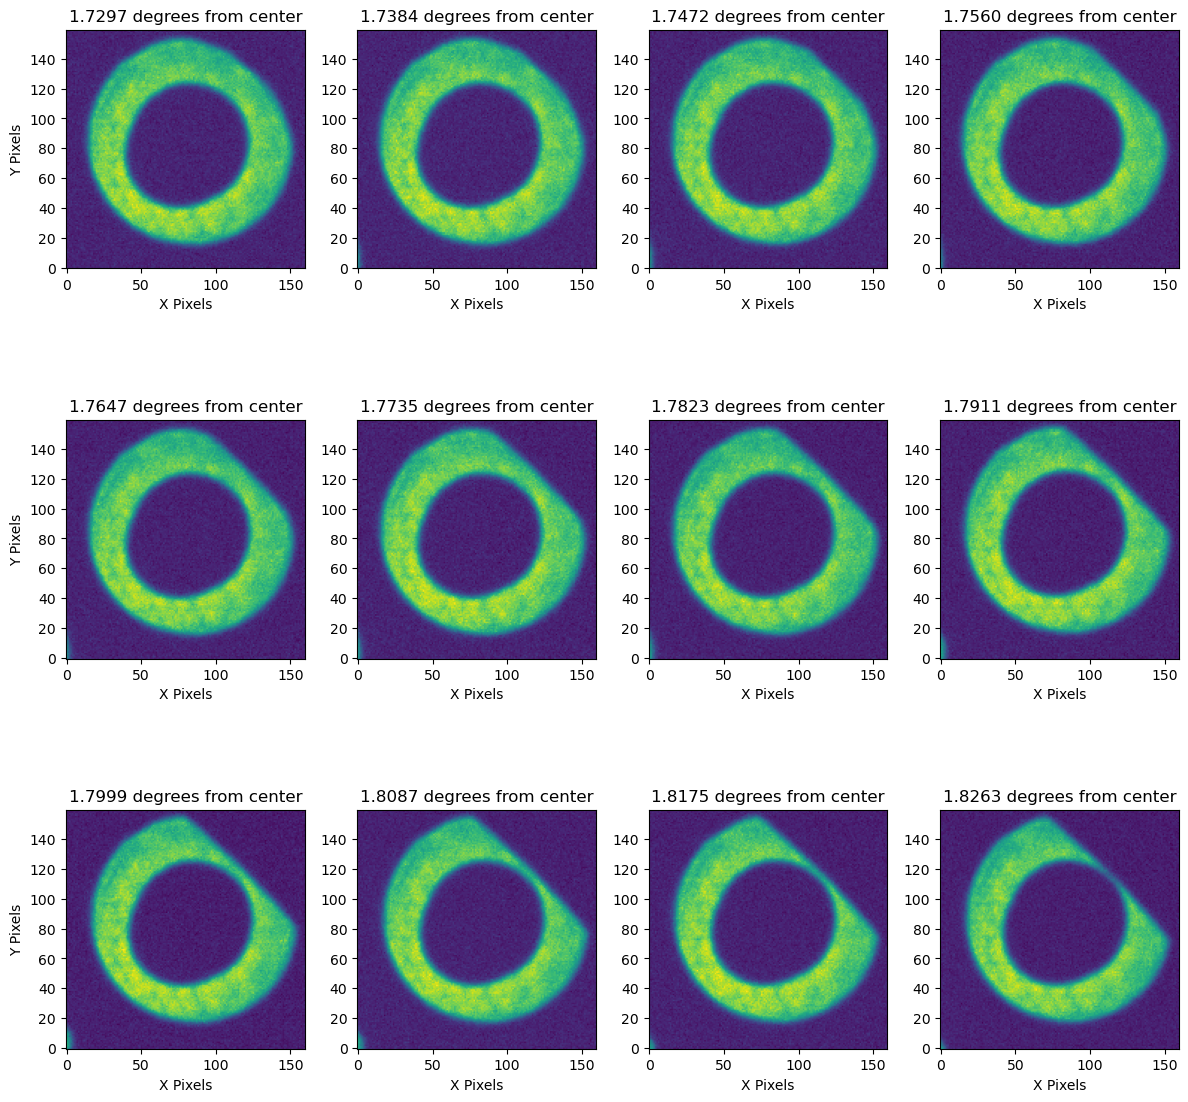

In [6]:
fig = plt.figure(figsize=(12, 12))
distToCenterVals = []
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    dStamp = donutStampsIntra[i]
    plt.imshow(dStamp.stamp_im.getImage().getArray())
    ra = dStamp.sky_position[0].asDegrees()
    dec = dStamp.sky_position[1].asDegrees()
    distToCenter = np.sqrt((ra)**2 + dec**2)
    distToCenterVals.append(distToCenter)
    plt.title(f'{distToCenter:.4f} degrees from center')
    plt.xlabel('X Pixels')
    if i in [0, 4, 8]:
        plt.ylabel('Y Pixels')
plt.tight_layout()

Finally, we show the masks that are used in the closed loop and display that the existing model adds vignetting when calculating the masks.

In [7]:
instDataPath = os.path.join(getConfigDir(), 'cwfs', 'instData')
maskDataPath = os.path.join(instDataPath, 'lsst', 'maskMigrate.yaml')
inst = Instrument()
inst.configFromFile(160, CamType.LsstCam, maskConfigFile=maskDataPath)

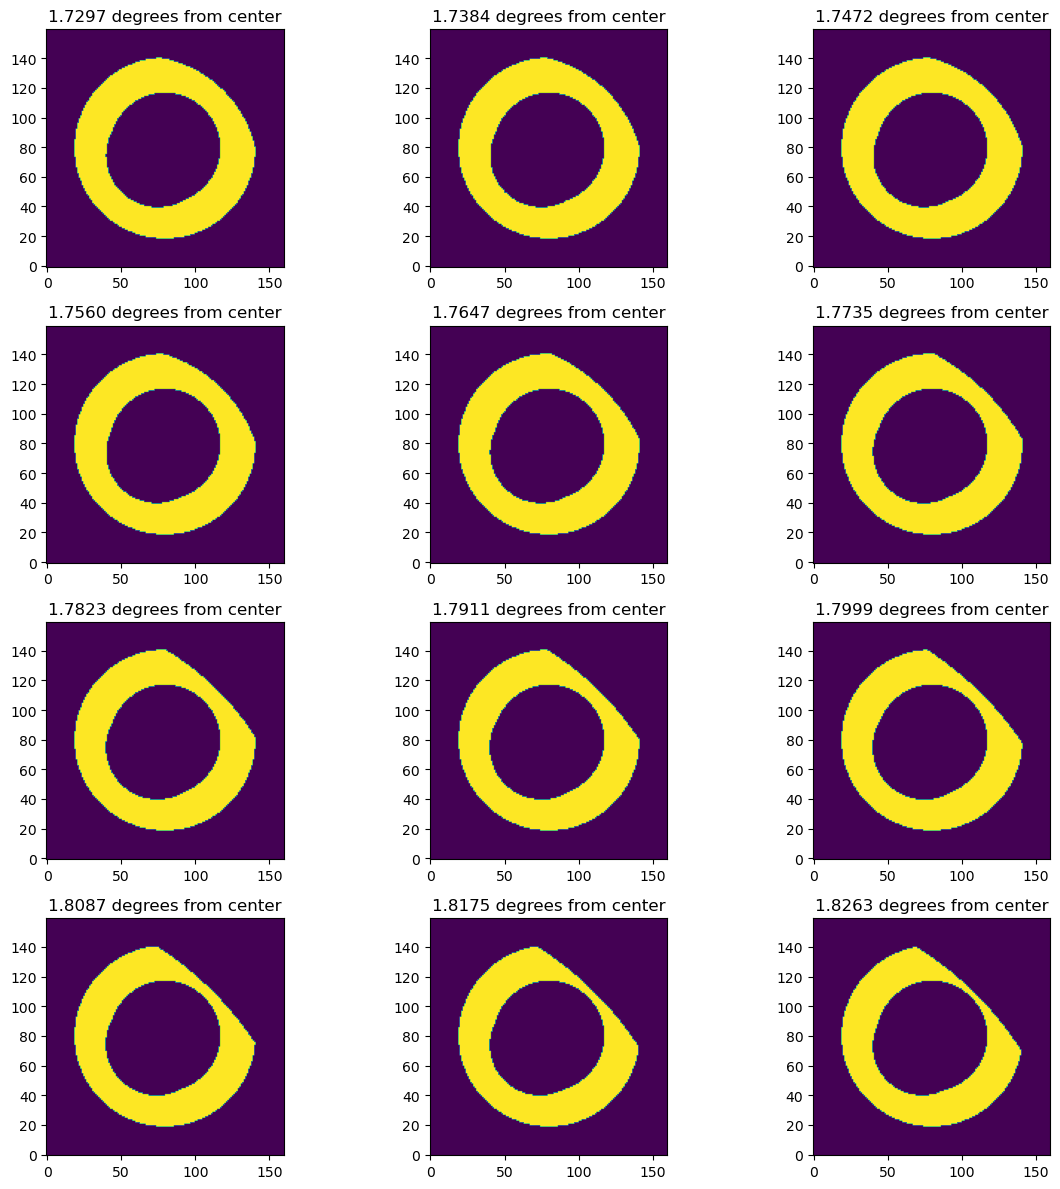

In [8]:
fig = plt.figure(figsize=(12, 12))
distToCenterVals = []
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    dStamp = donutStampsIntra[i]
    dStamp.makeMasks(inst, 'offAxis', 0, 1)
    plt.imshow(dStamp.mask_comp.getArray())
    ra = donutStampsIntra[i].sky_position[0].asDegrees()
    dec = donutStampsIntra[i].sky_position[1].asDegrees()
    distToCenter = np.sqrt((ra)**2 + dec**2)
    distToCenterVals.append(distToCenter)
    plt.title(f'{distToCenter:.4f} degrees from center')
plt.tight_layout()

## Zernike Estimation Performance of Vignetted Donuts

For the rest of the notebook we use a series of runs in which we take a single extra-focal donut always at the same location and a single intra-focal donut at a different distance from the center of the field and run the full closed loop simulation. 

In this section for each wavefront sensor pair we load the Zernike coefficients from the first iteration of the closed loop. We then compare these results with the OPD values to see how well we can reproduce the true values with varying levels of vignetting".

In [9]:
field_distances = []
for dir_name in os.listdir(supporting_data_folder):
    field_dist = dir_name.split('_')[2]
    if field_dist == 'all':
        continue
    field_distances.append(field_dist)
field_distances.sort()

In [10]:
detectorZerns = {}
for extraId in extraDetectorIds:
    dataIdExtra = extraDataIds[str(extraId)]
    zernVals = []
    for field_dist in field_distances:
        # Repository with simulated data
        with open(os.path.join(f'{supporting_data_folder}/single_donut_{field_dist}/iter0/img/wfs.zer'), 'r') as f:
            wfs_truth = yaml.safe_load(f)
        #for det_num in [191, 195, 199, 203]:
            wfs_str_list = wfs_truth[extraId]
            wfs_truth[extraId] = np.loadtxt(wfs_str_list)
            zernVals.append(wfs_truth[extraId])

    detectorZerns[str(extraId)] = zernVals

In [11]:
# Load the OPD "Truth" information
with  open(os.path.join(f'{supporting_data_folder}/single_donut_{field_dist}/iter0/img/opd.zer'), 'r') as f:
    opd_truth = yaml.safe_load(f)
for det_num in [191, 195, 199, 203]:
    opd_str_list = opd_truth[det_num]
    opd_truth[det_num] = np.loadtxt(opd_str_list)

In [12]:
camera = butler.get('camera', dataId={'instrument':'LSSTCam'}, collections='LSSTCam/calib/unbounded')

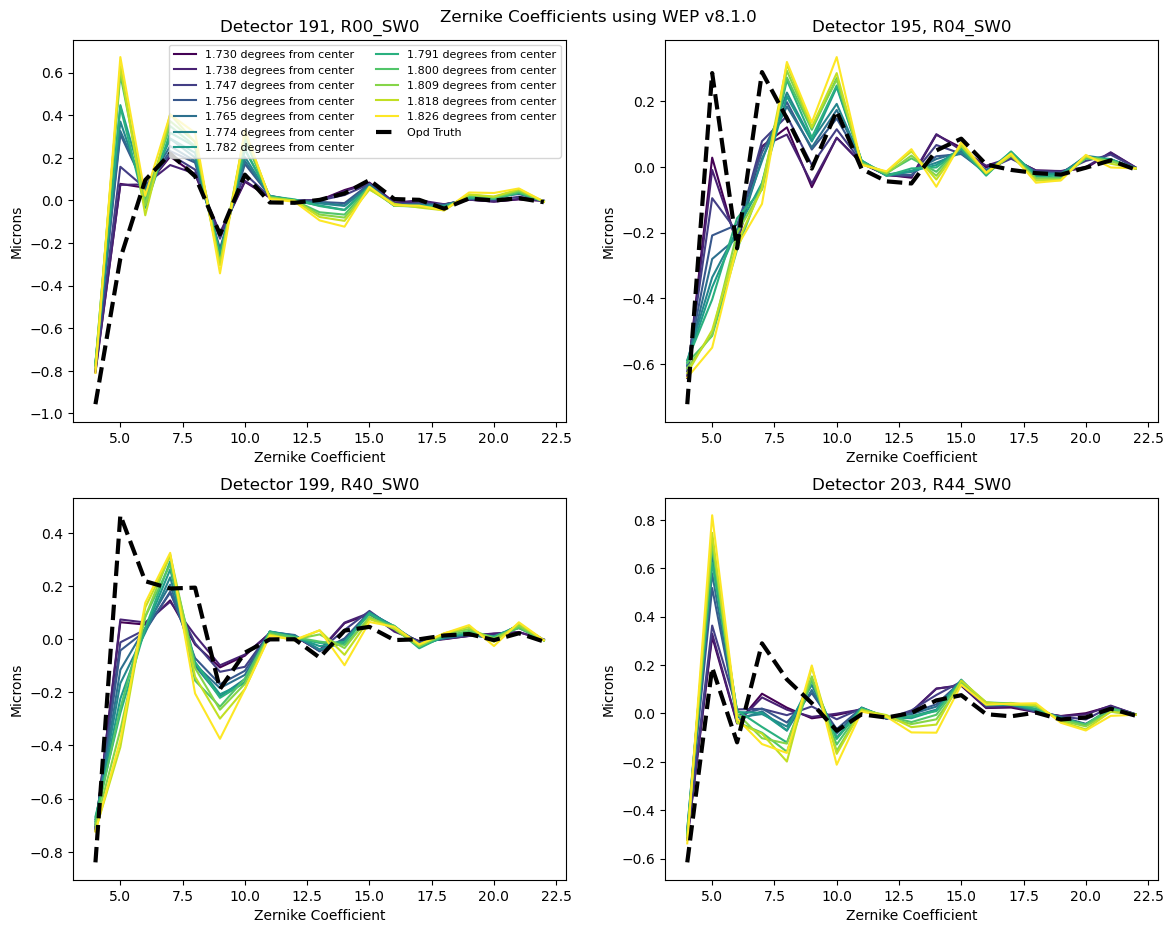

In [13]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))

n = len(distToCenterVals)
colors = plt.cm.viridis(np.linspace(0,1,n))

for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(12):
        plt.plot(np.arange(4, 23), detectorZerns[str(extraId)][j], label=f'{distToCenterVals[j]:.3f} degrees from center', c=colors[j])
    plt.plot(np.arange(4, 23), opd_truth[extraId]/1e3, '--', label=f'Opd Truth', lw=3, c='k')
    if i == 1:
        plt.legend(loc=1, ncol=2, fontsize=8)
    plt.title(f'Detector {extraId}, {camera[extraId].getName()}')
    plt.ylabel('Microns')
    plt.xlabel('Zernike Coefficient')
    i+=1
plt.suptitle('Zernike Coefficients using WEP v8.1.0')
plt.subplots_adjust(top=0.95)

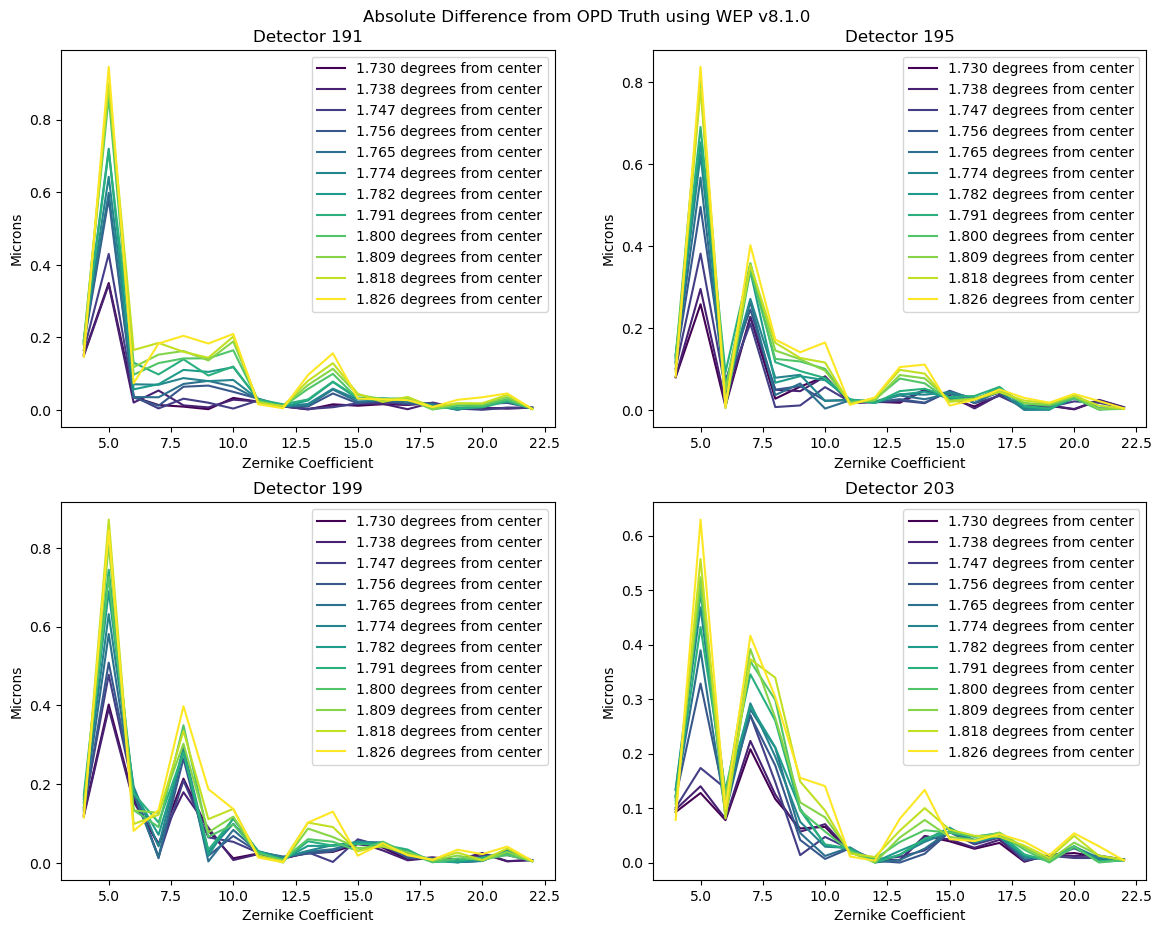

In [14]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))
for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(12):
        plt.plot(
            np.arange(4, 23), 
            np.abs(detectorZerns[str(extraId)][j]-opd_truth[extraId]/1e3), 
            label=f'{distToCenterVals[j]:.3f} degrees from center',
            c=colors[j]
        )
    plt.legend()
    plt.title(f'Detector {extraId}')
    plt.ylabel('Microns')
    plt.xlabel('Zernike Coefficient')
    i+=1
plt.suptitle('Absolute Difference from OPD Truth using WEP v8.1.0')
plt.subplots_adjust(top=0.94)

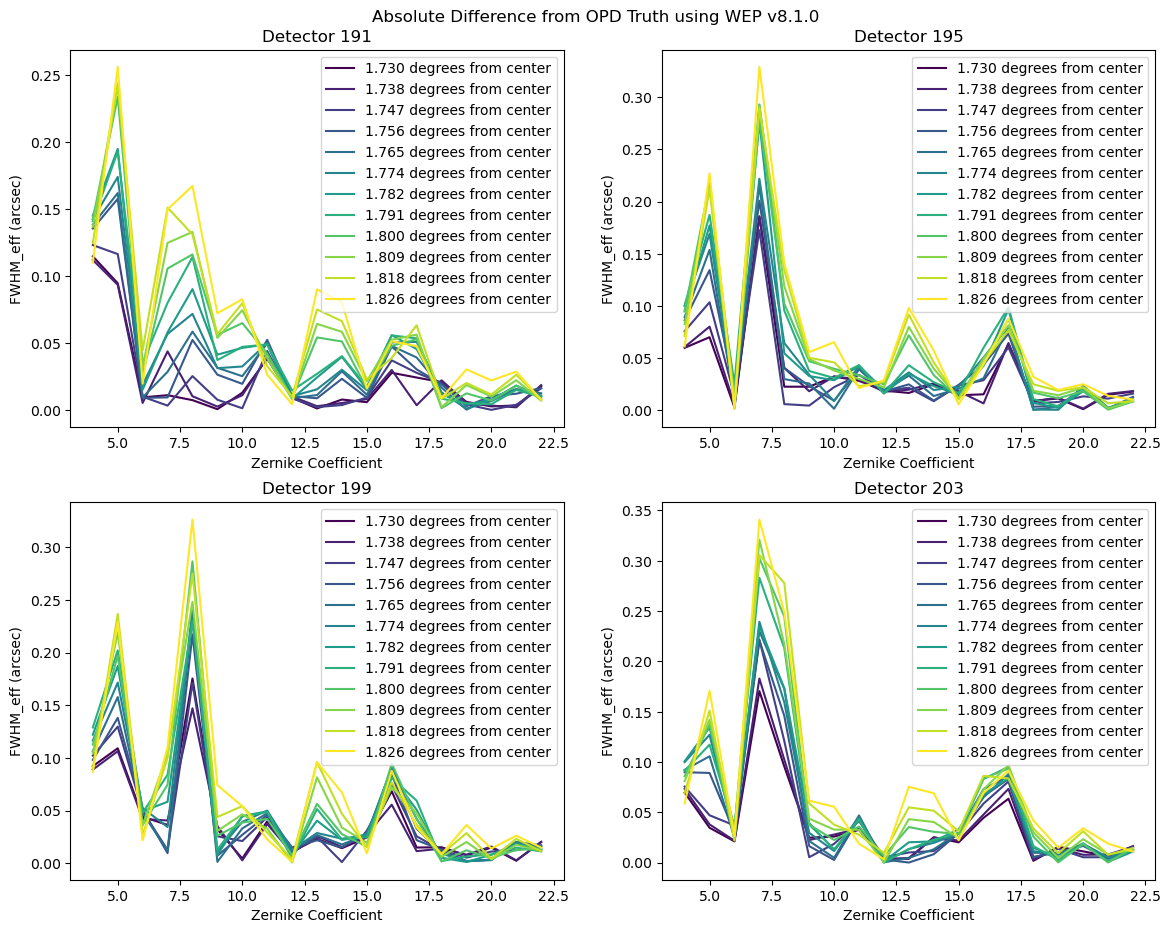

In [15]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))
for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(12):
        plt.plot(
            np.arange(4, 23), 
            ConvertZernikesToPsfWidth(np.abs(detectorZerns[str(extraId)][j]-opd_truth[extraId]/1e3)), 
            label=f'{distToCenterVals[j]:.3f} degrees from center', 
            c=colors[j]
        )
    plt.legend()
    plt.title(f'Detector {extraId}')
    plt.ylabel('FWHM_eff (arcsec)')
    plt.xlabel('Zernike Coefficient')
    i+=1
plt.suptitle('Absolute Difference from OPD Truth using WEP v8.1.0')
plt.subplots_adjust(top=0.94)

We can see that the WEP estimates get progressively worse compared to the OPD truth as we move to greater vignetting of the intra-focal donut. Looking at the differences in the individual Zernike measurements we see that for some Zernike modes (e.g., Z4, Z6, or Z11) the errors to the OPD are consistent as we move outward but that other Zernikes especially Z5, Z7, and Z8 have a strong negative effect from the vignetting. Looking at the images of the Zernike polynomials below we can see this corresponds to Zernikes that primarily measure intensity along the diagonal direction. For instance look see Z5 vs Z6, Z6 is not affected significantly by vignetting but is vertical astigmatism and measures defects parallel to the x and y axes but Z5 is greatly affected as oblique astigmatism measures defects along the diagonal axis of the wavefront.

In [16]:
Image(url='https://sitcomtn-003.lsst.io/_images/aZernikes.png')

Next we look at how the overall error in the wavefront estimate changes as a function of vignetting.

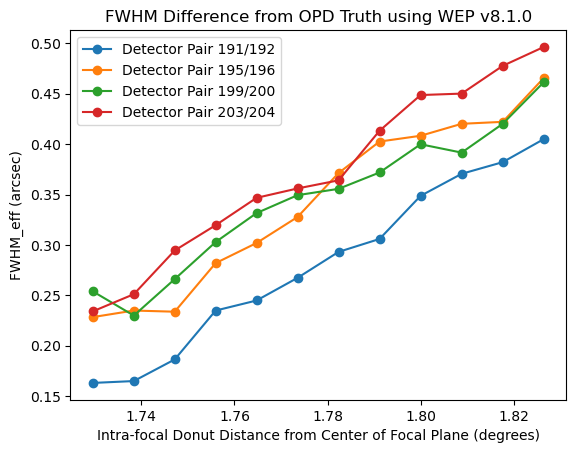

In [17]:
# Show zernikes on each sensor pair across different vignetting
i = 1
fig = plt.figure()
for extraId in extraDetectorIds:
    psfContrib = []
    for j in range(12):
        psfContrib.append(
            np.sqrt(np.sum(np.square(
                ConvertZernikesToPsfWidth(
                    detectorZerns[str(extraId)][j] - opd_truth[extraId]/1e3
                )
            )))
        )
    plt.plot(
        distToCenterVals, psfContrib, '-o', label=f'Detector Pair {extraId}/{extraId+1}'
    )
    i += 1
plt.ylabel('FWHM_eff (arcsec)')
plt.xlabel('Intra-focal Donut Distance from Center of Focal Plane (degrees)')
plt.title('FWHM Difference from OPD Truth using WEP v8.1.0')
plt.legend()

We see that there is a steady increase in the overall wavefront error as we move closer to the edge of the intra-focal sensor and vignetting increases.

In the next section we make sure that we look to see how this affects the convergence of the AOS closed loop. Finally, using convergence of the closed loop as the determining factor we will try to define a limit for acceptable donuts based upon their distance from the center of the focal plane.

## Closed loop results with vignetting

In this section we look at the performance of the closed loop with varying amounts of vignetting.

### With background, `g_mag` = 14.0

In our tests all the stars are set to `g_mag` = 14.0 and we include sky background and atmospheric effects in the `imSim` simulations.

In [18]:
field_distances = []
for dir_name in os.listdir(supporting_data_folder):
    field_dist = dir_name.split('_')[2]
    if field_dist == 'all':
        continue
    field_distances.append(field_dist)
field_distances.sort()

In [19]:
PSSN_vals = {}
for field_dist in field_distances:
    loop_PSSN = []
    for loop_iter in range(10):
        loop_PSSN.append(np.genfromtxt(os.path.join(f'{supporting_data_folder}/single_donut_{field_dist}/iter{loop_iter}/img/PSSN.txt')))
    PSSN_vals[field_dist] = np.array(loop_PSSN)

Text(0.5, 1.0, 'Closed Loop, 10 iterations, With Background, g=14.0')

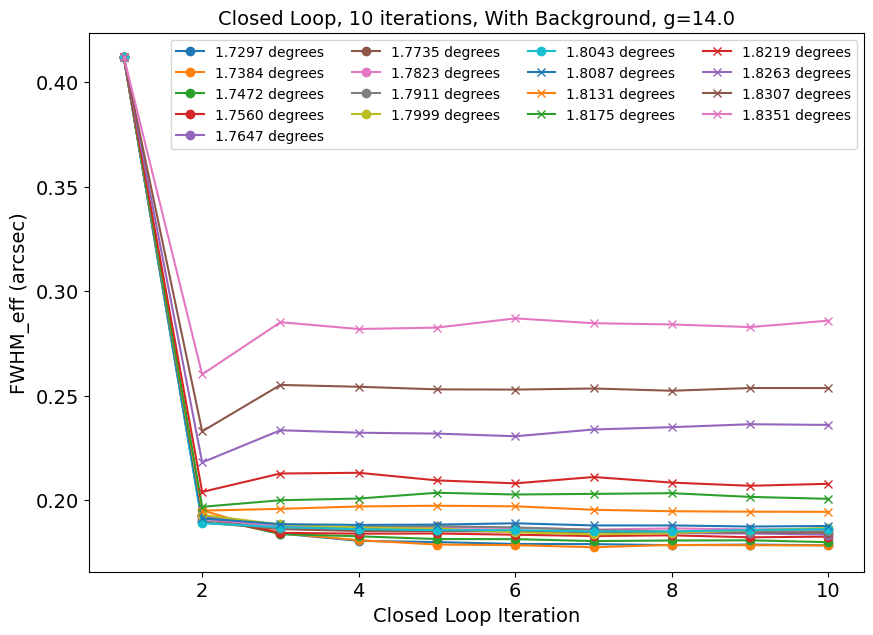

In [20]:
fig = plt.figure(figsize=(10, 7))
for field_dist in field_distances[:10]:
    plt.plot(
        np.arange(1, 11),
        PSSN_vals[field_dist][:, 1, 4], 
        '-o', 
        label=f"{field_dist} degrees"
    )
for field_dist in field_distances[10:]:
    plt.plot(
        np.arange(1, 11),
        PSSN_vals[field_dist][:, 1, 4], 
        '-x', 
        label=f"{field_dist} degrees"
    )
plt.legend(fontsize=10, ncol=4)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop, 10 iterations, With Background, g=14.0', size=14)

Text(0.5, 1.0, 'Closed Loop, Iterations 2-10, With Background, g=14.0')

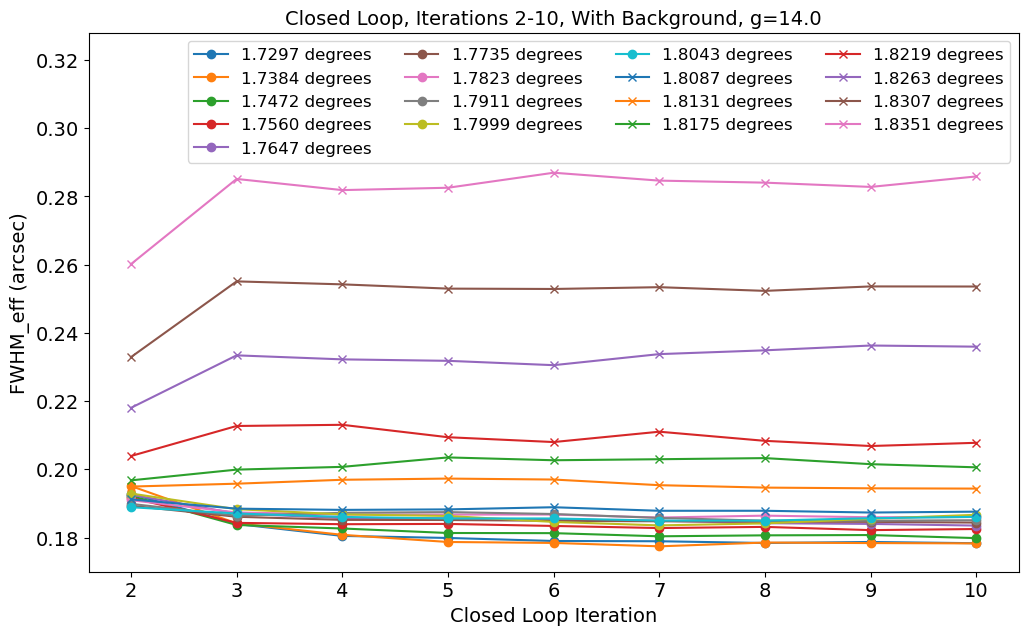

In [21]:
fig = plt.figure(figsize=(12, 7))
for field_dist in field_distances[:10]:
    plt.plot(
        np.arange(2, 11),
        PSSN_vals[field_dist][1:, 1, 4], 
        '-o', 
        label=f"{field_dist} degrees"
    )
for field_dist in field_distances[10:]:
    plt.plot(
        np.arange(2, 11),
        PSSN_vals[field_dist][1:, 1, 4], 
        '-x', 
        label=f"{field_dist} degrees"
    )
plt.legend(fontsize=12, ncol=4)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim((0.17, 0.328))
plt.title('Closed Loop, Iterations 2-10, With Background, g=14.0', size=14)

Text(0.5, 1.0, 'Closed Loop, Iterations 2-10, With Background, g=14.0')

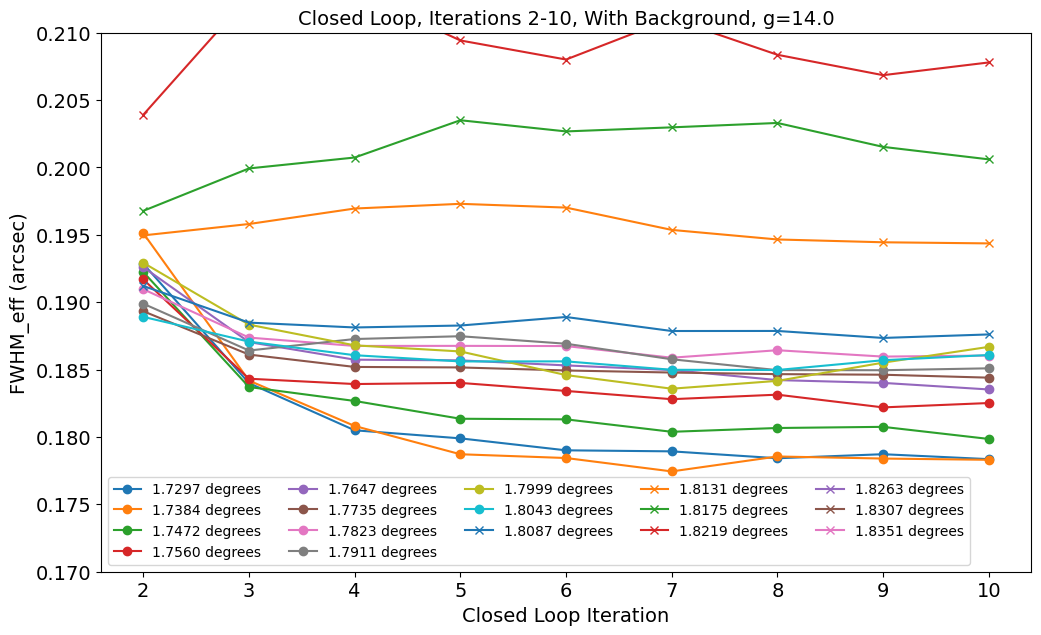

In [22]:
fig = plt.figure(figsize=(12, 7))
for field_dist in field_distances[:10]:
    plt.plot(
        np.arange(2, 11),
        PSSN_vals[field_dist][1:, 1, 4], 
        '-o', 
        label=f"{field_dist} degrees"
    )
for field_dist in field_distances[10:]:
    plt.plot(
        np.arange(2, 11),
        PSSN_vals[field_dist][1:, 1, 4], 
        '-x', 
        label=f"{field_dist} degrees"
    )
plt.legend(fontsize=10, ncol=5)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim((0.17, 0.21))
plt.title('Closed Loop, Iterations 2-10, With Background, g=14.0', size=14)

As we can see in the top two plots, all of the closed loop runs converge but there is a significant deterioration in the results at the highest level of vignetting.

In the bottom plot we zoom into iterations 2-10 and see that there are a group of very similar results up to and including donuts at 1.8087 degrees from the center of the focal plane. After this point there seems to be a slight deterioration of the FWHM convergence of about 0.005 arcseconds each time we move out first to 1.8131 then to 1.8175 and 1.8219 degrees. The highest amount of vignetting in our simulations at 1.8351 degrees from the center of the focal plane also converges but at around 0.29 arcsec which is ~0.1 arcsec worse than the non-vignetted value.

## Calculate area of detector cut off

Here we will calculate the distance each pixel in the intra-focal detector is from the center of the field and then calculate how many pixels are beyond the limit we will set for the AOS baseline pipeline at 1.808 degrees.

In [23]:
intraIm = butler.get('postISRCCD', dataId=intraDataIds[str(192)], collections=['ts_imsim_1000'])

In [24]:
# Create meshgrid for contours and calculate distance to center for points in grid
import lsst.geom
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE

X, Y = np.meshgrid(np.arange(0, 4096, 5), np.arange(0, 2001, 5))
Z = np.zeros(np.shape(X))

for x_idx in np.arange(0, 4096, 5):
    for y_idx in np.arange(0, 2001, 5):
        # Use detector object to convert between Pixels and Field Angle
        field_xy = intraIm.getDetector().transform(
            lsst.geom.Point2D(x_idx, y_idx), PIXELS, FIELD_ANGLE
        )
        field_dist = np.sqrt(field_xy[0]**2 + field_xy[1]**2)
        Z[int(y_idx/5), int(x_idx/5)] = np.degrees(field_dist)


Text(0, 0.5, 'Y Pixels')

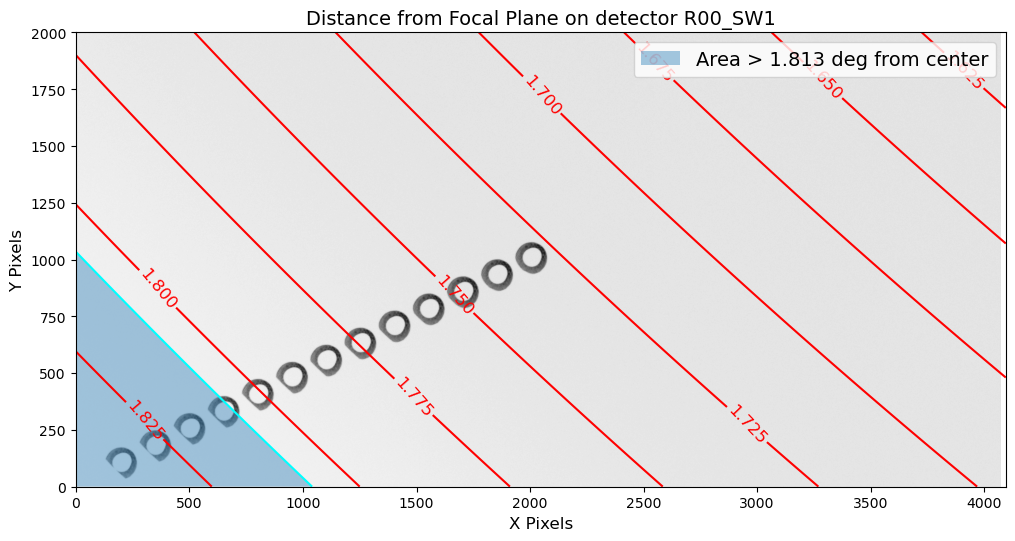

In [25]:
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
plt.imshow(intraIm.getImage().getArray(), cmap=plt.get_cmap('Greys'))
C = plt.contour(X, Y, Z, colors='red', levels=np.arange(1.60, 1.91, 0.025))
C1 = plt.contour(X, Y, Z, colors='cyan', levels=[1.808])
ax.clabel(C, inline=True, fontsize=12)
ax.fill_between(C1.allsegs[0][0][:,0], C1.allsegs[0][0][:,1], np.zeros(len(C1.allsegs[0][0])), alpha=0.4, label='Area > 1.813 deg from center')
plt.title(f'Distance from Focal Plane on detector {intraIm.getDetector().getName()}', size=14)
plt.legend(fontsize=14)
plt.xlabel('X Pixels', size=12)
plt.ylabel('Y Pixels', size=12)


In [26]:
frac_cutoff = len(np.where(Z > 1.808)[0])/(np.shape(Z)[0]*np.shape(Z)[1])

In [27]:
print(f"The amount of the detector cutoff is {frac_cutoff*100:.4f} percent for detector {intraIm.getDetector().getName()}.")

The amount of the detector cutoff is 6.5142 percent for detector R00_SW1.


Setting the limit of sources used in our baseline AOS pipeline still leaves us ~93.5% of the detector area. This seems acceptable and it does not look like we need to look at further vignetting algorithms but should focus our efforts on deblending to make sure we make the best use of the remaining 93.5% of the detector to get sources.